In [191]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from scipy.stats import kruskal, f_oneway
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import shapiro, levene
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [192]:
df = pd.read_csv("data.csv")
df

,fecha,estacion,tsm,ano,mes,chla,mes_num,est_index,longitud,latitud,evento,oni,estacion_climatica
0,1981-09-01,est_1,30.5000,NaN,9,NaN,NaN,0.0,-109.3,23.8,Neutro,-0.2,SON
1,1981-09-01,est_10,28.6250,NaN,9,NaN,NaN,9.0,-112.3,27.6,Neutro,-0.2,SON
2,1981-09-01,est_11,29.1583,NaN,9,NaN,NaN,10.0,-112.6,28.0,Neutro,-0.2,SON
3,1981-09-01,est_12,28.8750,NaN,9,NaN,NaN,11.0,-112.9,28.5,Neutro,-0.2,SON
4,1981-09-01,est_13,26.9667,NaN,9,NaN,NaN,12.0,-113.2,28.9,Neutro,-0.2,SON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7577,2018-10-01,est_5,29.0756,2018.0,10,0.2772,10.0,4.0,-110.8,25.3,Niño,0.8,SON
7578,2018-10-01,est_6,28.6689,2018.0,10,0.3656,10.0,5.0,-111.1,25.8,Niño,0.8,SON
7579,2018-10-01,est_7,28.7222,2018.0,10,0.5083,10.0,6.0,-111.2,26.3,Niño,0.8,SON
7580,2018-10-01,est_8,28.4456,2018.0,10,0.5119,10.0,7.0,-111.5,26.8,Niño,0.8,SON


In [193]:
df.duplicated().unique()

array([False])

In [194]:
print("\nCantidad de filas cond datos faltantes por columna:")
print(df.isna().sum())


Cantidad de filas cond datos faltantes por columna:
fecha                    0
estacion                 0
tsm                      0
ano                   3264
mes                      0
chla                  3264
mes_num               3264
est_index                0
longitud                 0
latitud                  0
evento                   0
oni                      0
estacion_climatica       0
dtype: int64


In [195]:
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values('fecha')
df['year'] = df['fecha'].dt.year
df['year_group'] = (df['year'] // 10) * 10
df['evento'] = df['evento'].astype('category')

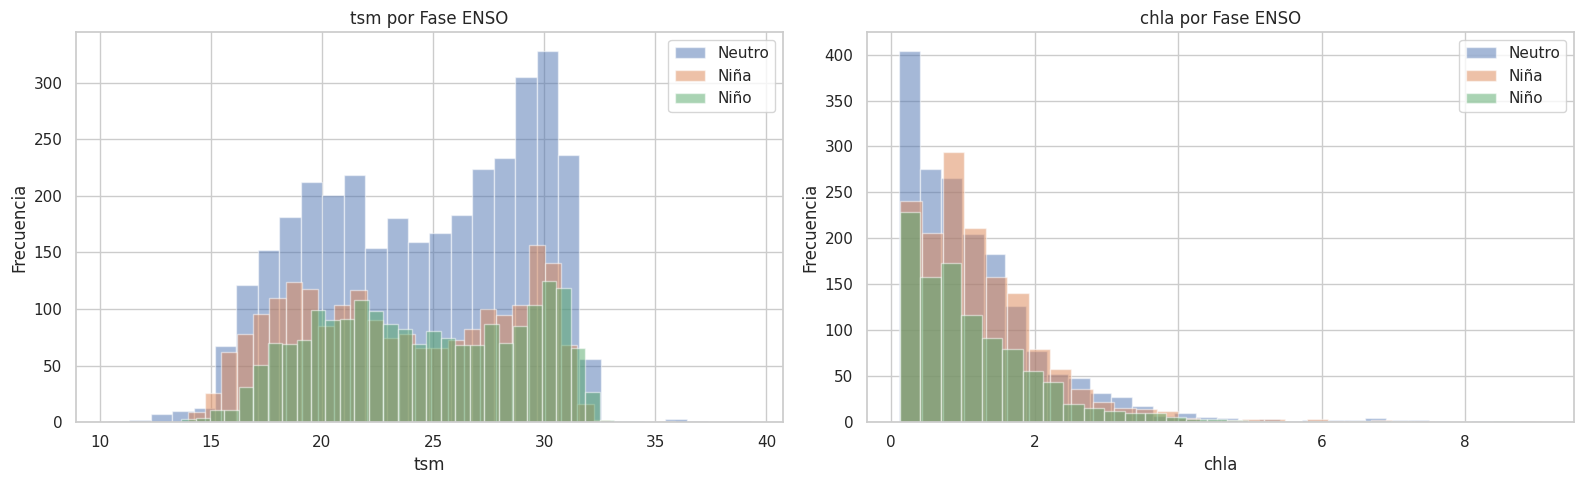

In [196]:
columns_to_plot = ['tsm', 'chla']

fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(8 * len(columns_to_plot), 5), sharey=False)

for ax, col in zip(axes, columns_to_plot):
    for evento, grupo in df.groupby('evento', observed=False):
        grupo[col].dropna().plot(
            kind='hist',
            bins=30,
            alpha=0.5,
            ax=ax,
            label=str(evento)
        )
    ax.set_title(f"{col} por Fase ENSO")
    ax.set_xlabel(col)
    ax.set_ylabel("Frecuencia")
    ax.legend()

plt.tight_layout()
plt.show()

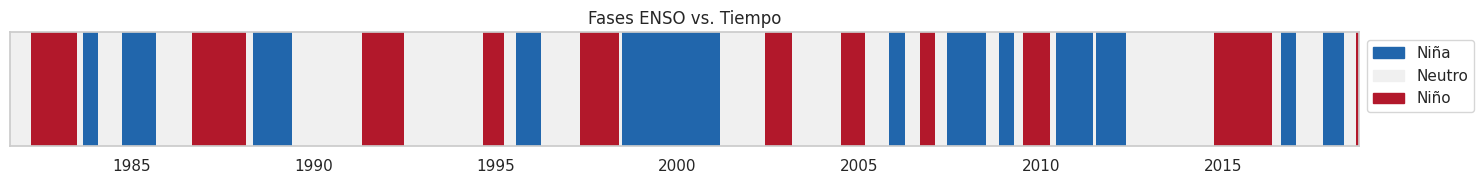

In [197]:
enso_colors = {
    "Niña": "#2166ac", # Azulito por temperatura mas alta de lo usual
    "Neutro": "#f0f0f0", # Rojito por temperatura mas alta de lo usual
    "Niño": "#b2182b" # Rojito por temperatura mas alta de lo usual
}

df['enso_color'] = df['evento'].map(enso_colors)

fig, ax = plt.subplots(figsize=(15, 2))

for i in range(len(df) - 1):
    ax.axvspan(df['fecha'].iloc[i], df['fecha'].iloc[i + 1], color=df['enso_color'].iloc[i], linewidth=0)

ax.set_xlim(df['fecha'].min(), df['fecha'].max())
ax.set_yticks([])
ax.set_title("Fases ENSO vs. Tiempo")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

handles = [mpatches.Patch(color=color, label=label) for label, color in enso_colors.items()]
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [198]:
# Mapa de colores por Fase ENSO
enso_colors = {"Niña": "#2166ac", "Neutro": "#f0f0f0", "Niño": "#b2182b"}

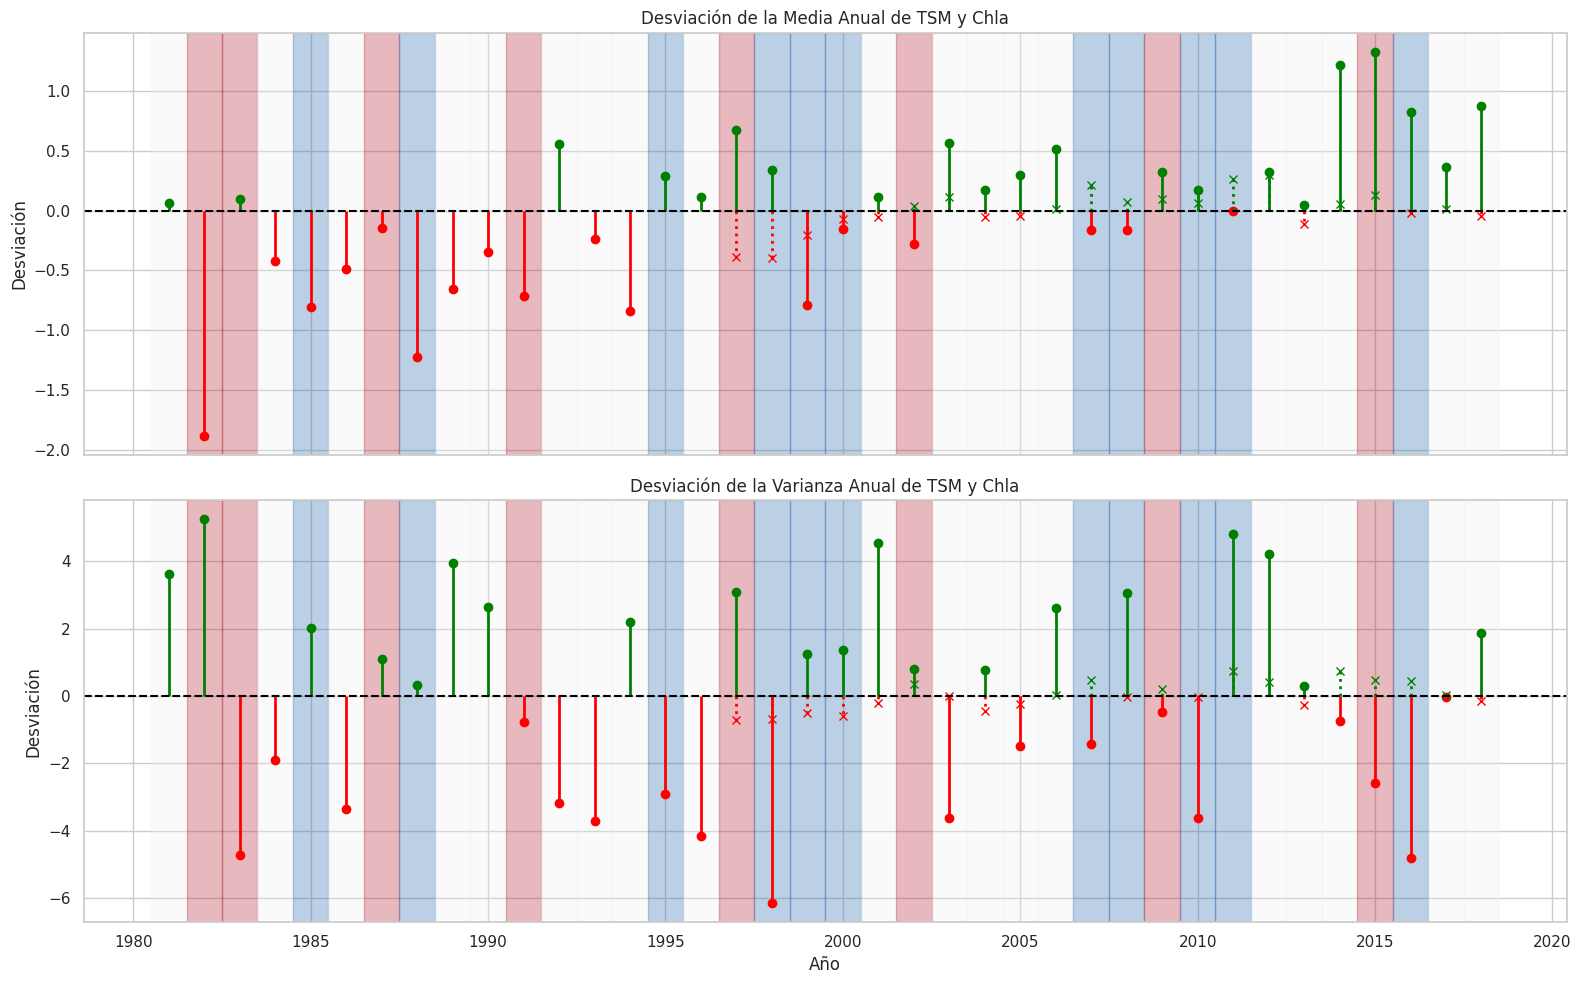

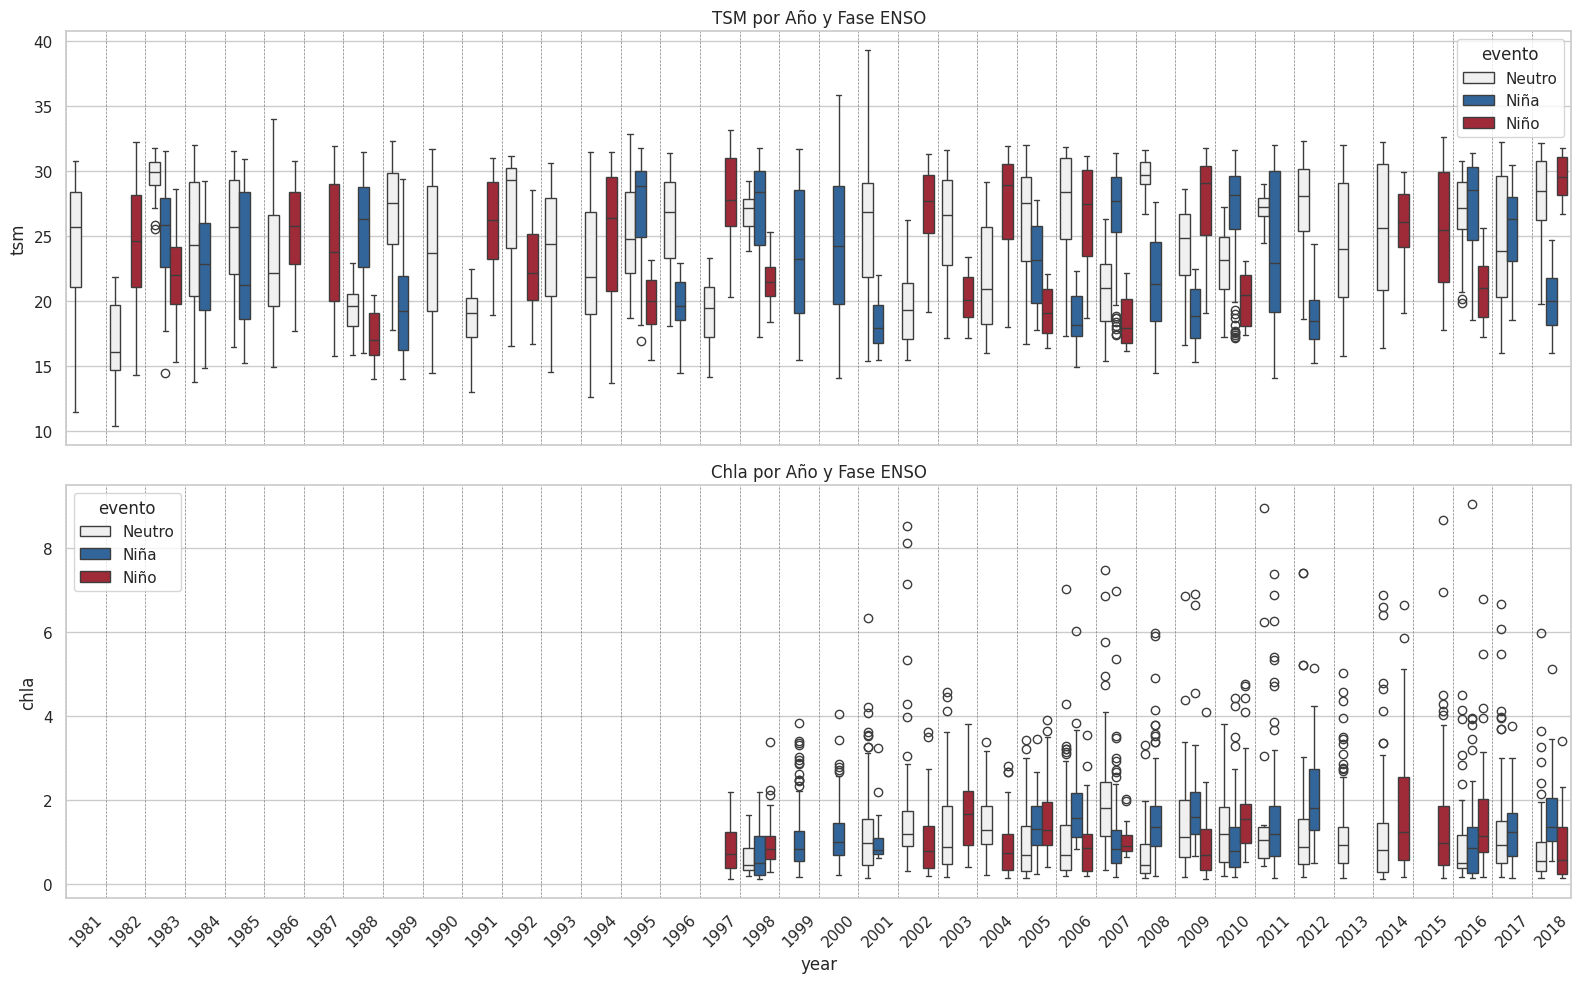

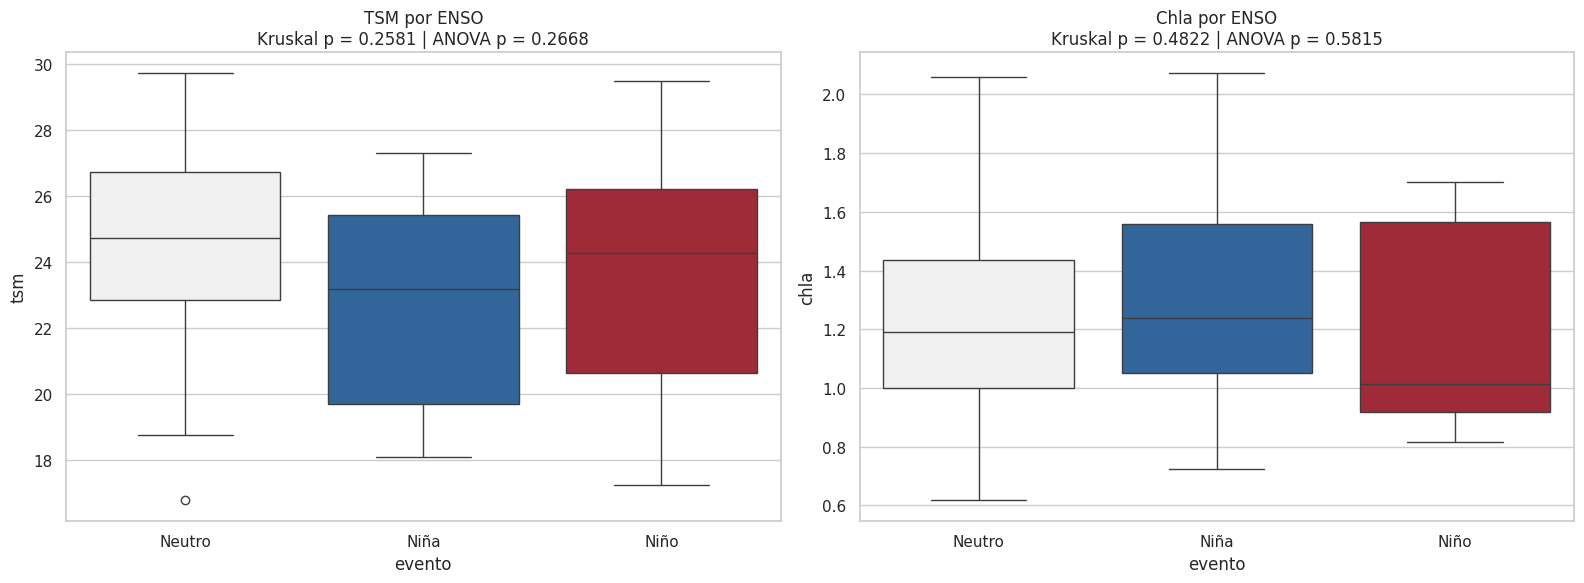

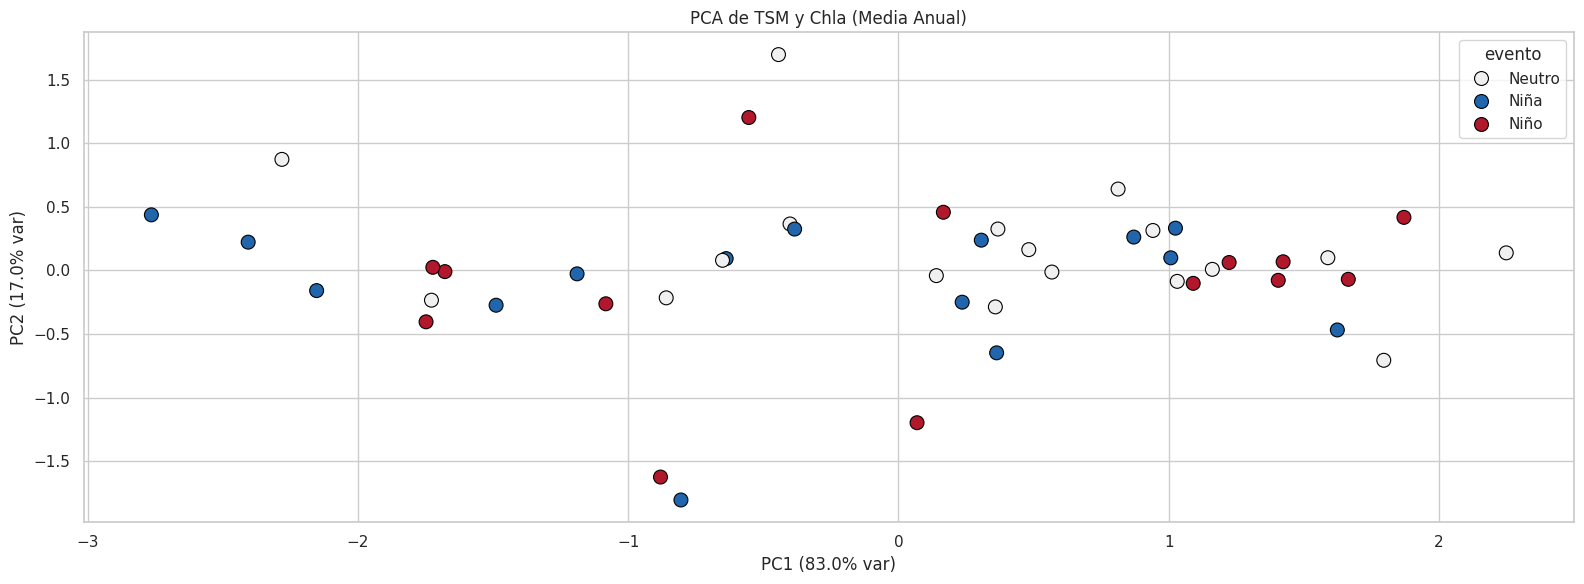


Contribución de cada variable a los componentes principales (PCA):
        PC1    PC2
tsm   0.707  0.707
chla -0.707  0.707


In [199]:
# Agrupamiento de ENSO por anio
enso_years = df.groupby('year', observed=False)['evento'].agg(lambda x: x.mode().iloc[0])

# Calculo de Desviacion de la Media y de Desviacion de la Media de la Varianza
tsm_mean = df.groupby('year', observed=False)['tsm'].mean()
chla_mean = df.groupby('year', observed=False)['chla'].mean()
tsm_var = df.groupby('year', observed=False)['tsm'].var()
chla_var = df.groupby('year', observed=False)['chla'].var()

tsm_mean_dev = tsm_mean - tsm_mean.mean()
chla_mean_dev = chla_mean - chla_mean.mean()
tsm_var_dev = tsm_var - tsm_var.mean()
chla_var_dev = chla_var - chla_var.mean()

def shade_enso(ax, index):
    for year in index:
        color = enso_colors.get(enso_years.get(year), "#dddddd")
        ax.axvspan(year - 0.5, year + 0.5, color=color, alpha=0.3)

# Graficos de Desviacion de la Media y de Desviacion de la Media de la Varianza
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Desviacion de la Media
ax = axes[0]
shade_enso(ax, tsm_mean.index)
for x, y in zip(tsm_mean_dev.index, tsm_mean_dev.values):
    ax.vlines(x, 0, y, color='green' if y >= 0 else 'red', linewidth=2)
    ax.plot(x, y, 'o', color='green' if y >= 0 else 'red')
for x, y in zip(chla_mean_dev.index, chla_mean_dev.values):
    ax.vlines(x, 0, y, color='green' if y >= 0 else 'red', linewidth=2, linestyle='dotted')
    ax.plot(x, y, 'x', color='green' if y >= 0 else 'red')
ax.axhline(0, color='black', linestyle='--')
ax.set_title("Desviación de la Media Anual de TSM y Chla")
ax.set_ylabel("Desviación")
ax.grid(True)

# Desviacion de la Varianza Media
ax = axes[1]
shade_enso(ax, tsm_var.index)
for x, y in zip(tsm_var_dev.index, tsm_var_dev.values):
    ax.vlines(x, 0, y, color='green' if y >= 0 else 'red', linewidth=2)
    ax.plot(x, y, 'o', color='green' if y >= 0 else 'red')
for x, y in zip(chla_var_dev.index, chla_var_dev.values):
    ax.vlines(x, 0, y, color='green' if y >= 0 else 'red', linewidth=2, linestyle='dotted')
    ax.plot(x, y, 'x', color='green' if y >= 0 else 'red')
ax.axhline(0, color='black', linestyle='--')
ax.set_title("Desviación de la Varianza Anual de TSM y Chla")
ax.set_ylabel("Desviación")
ax.set_xlabel("Año")
ax.grid(True)
plt.tight_layout()
plt.show()

# Boxplots
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
sns.boxplot(data=df, x='year', y='tsm', hue='evento', palette=enso_colors, ax=axes[0])
axes[0].set_title("TSM por Año y Fase ENSO")
sns.boxplot(data=df, x='year', y='chla', hue='evento', palette=enso_colors, ax=axes[1])
axes[1].set_title("Chla por Año y Fase ENSO")
for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    for year in sorted(df['year'].unique()):
        ax.axvline(x=list(sorted(df['year'].unique())).index(year) - 0.5, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Kruskal-Wallis & ANOVA
annual_means = df.groupby(['year', 'evento'], observed=False)[['tsm', 'chla']].mean().reset_index()
tsm_groups = [g['tsm'].dropna().values for _, g in annual_means.groupby('evento', observed=False) if len(g) >= 2]
chla_groups = [g['chla'].dropna().values for _, g in annual_means.groupby('evento', observed=False) if len(g) >= 2]
tsm_h, tsm_p_kruskal = kruskal(*tsm_groups)
tsm_f, tsm_p_anova = f_oneway(*tsm_groups)
chla_h, chla_p_kruskal = kruskal(*chla_groups)
chla_f, chla_p_anova = f_oneway(*chla_groups)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(data=annual_means, x='evento', hue='evento', y='tsm', palette=enso_colors, ax=axes[0])
axes[0].set_title(f"TSM por ENSO\nKruskal p = {tsm_p_kruskal:.4f} | ANOVA p = {tsm_p_anova:.4f}")
sns.boxplot(data=annual_means, x='evento', hue='evento', y='chla', palette=enso_colors, ax=axes[1])
axes[1].set_title(f"Chla por ENSO\nKruskal p = {chla_p_kruskal:.4f} | ANOVA p = {chla_p_anova:.4f}")
plt.tight_layout()
plt.show()

# PCA
annual_means_clean = annual_means.dropna(subset=['tsm', 'chla'])
X = annual_means_clean[['tsm', 'chla']].values
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['evento'] = annual_means_clean['evento'].values
pca_df['year'] = annual_means_clean['year'].values

plt.figure(figsize=(16, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='evento', palette=enso_colors, s=100, edgecolor='black')
plt.title("PCA de TSM y Chla (Media Anual)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.grid(True)
plt.tight_layout()
plt.show()

loadings = pd.DataFrame(
    pca.components_.T,
    index=['tsm', 'chla'],
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
print("\nContribución de cada variable a los componentes principales (PCA):")
print(loadings.round(3))

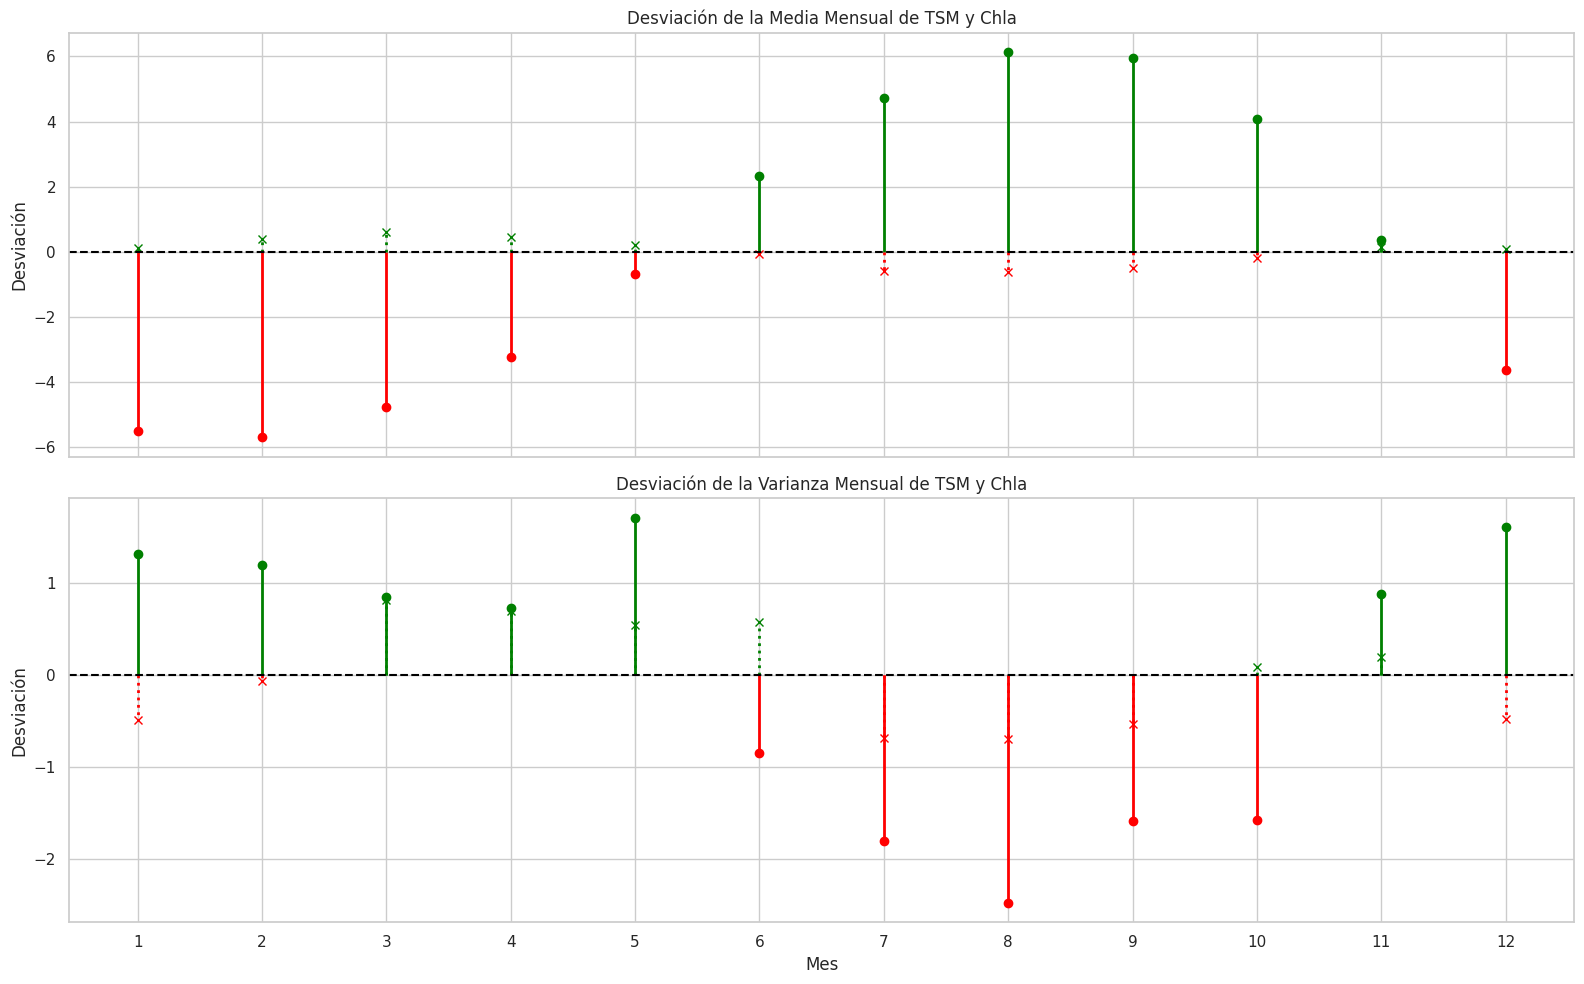

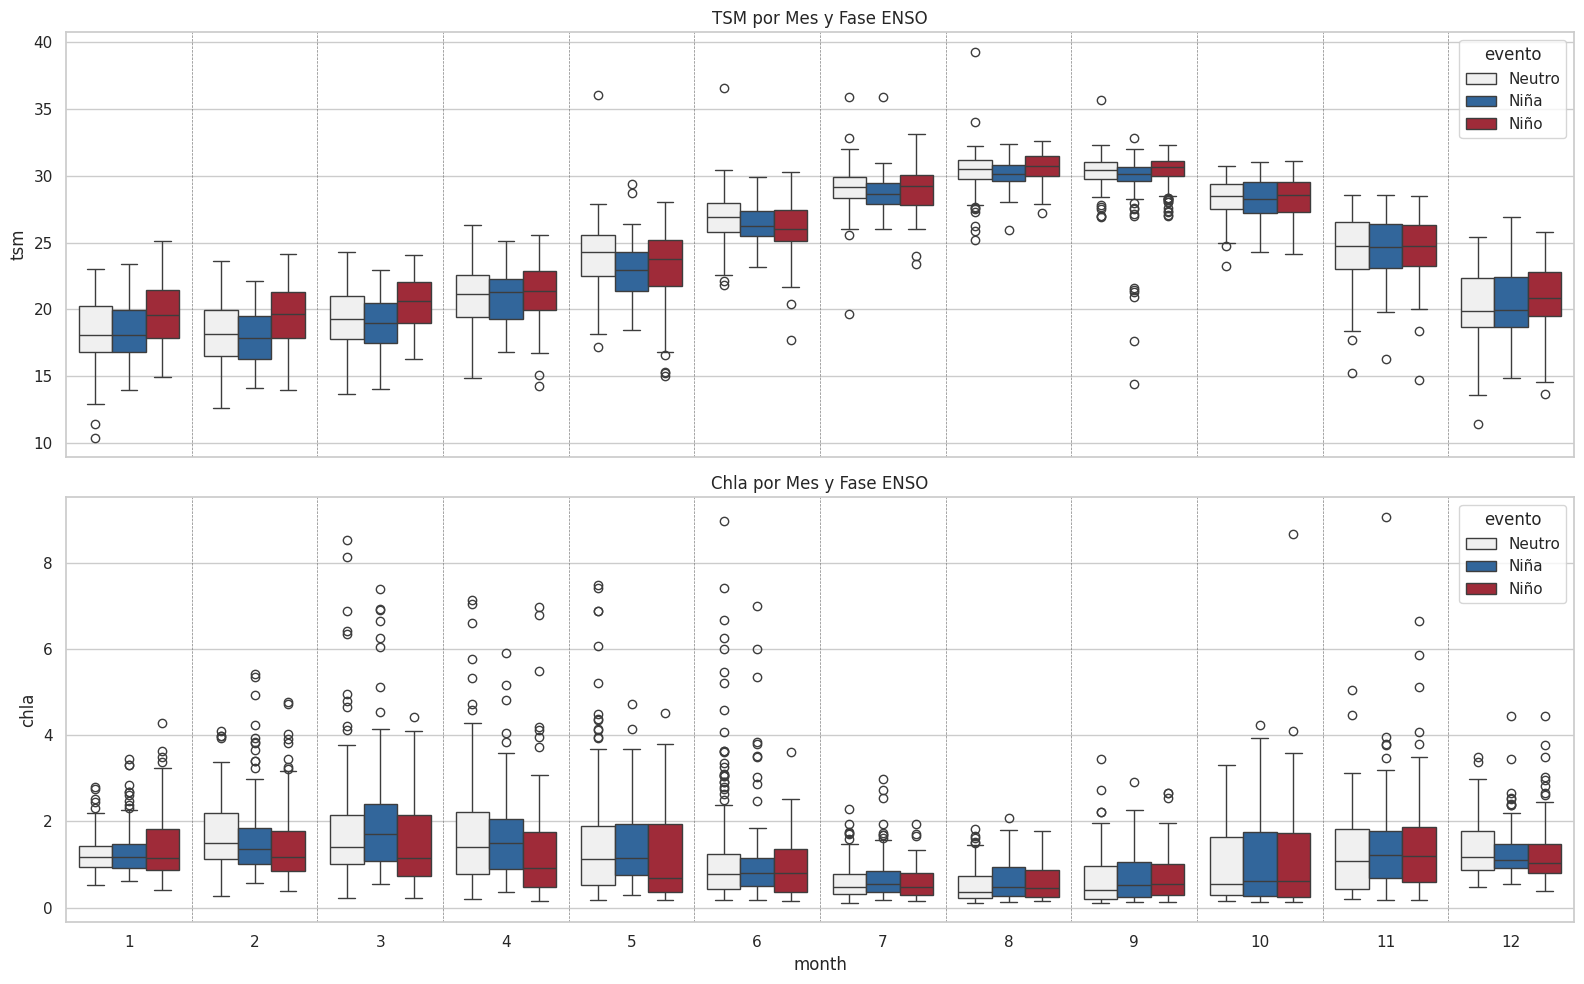

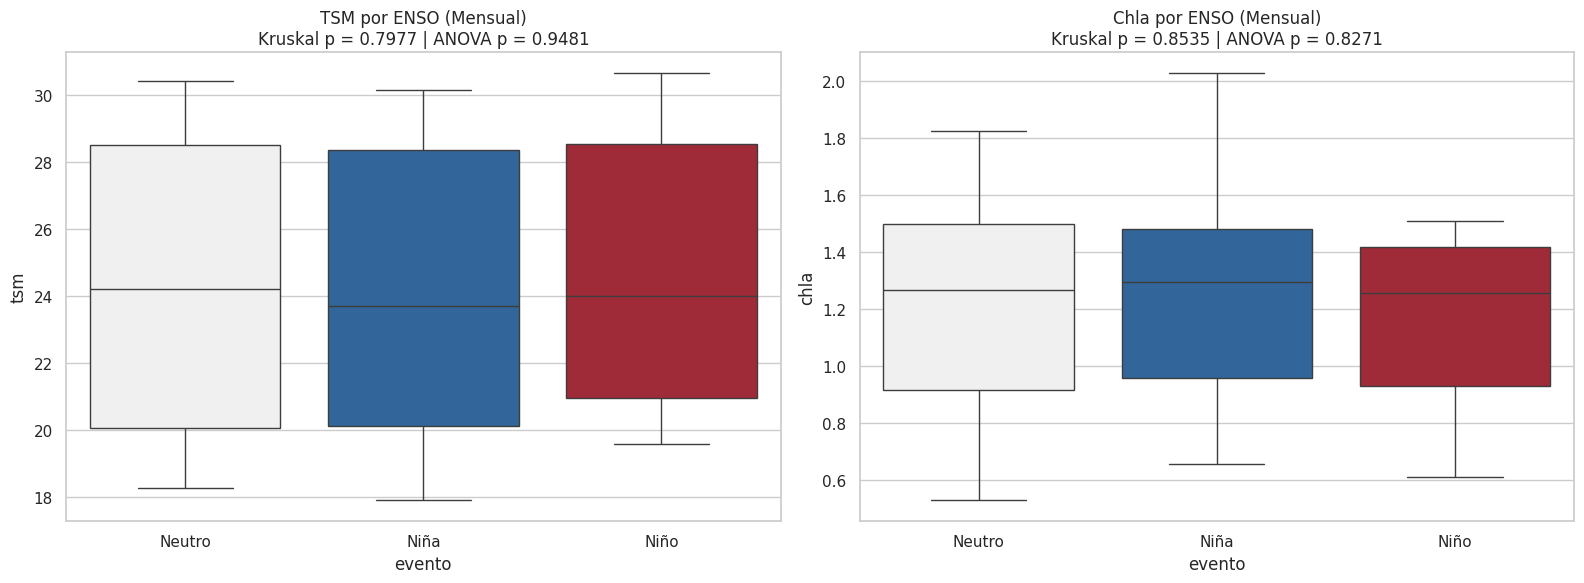

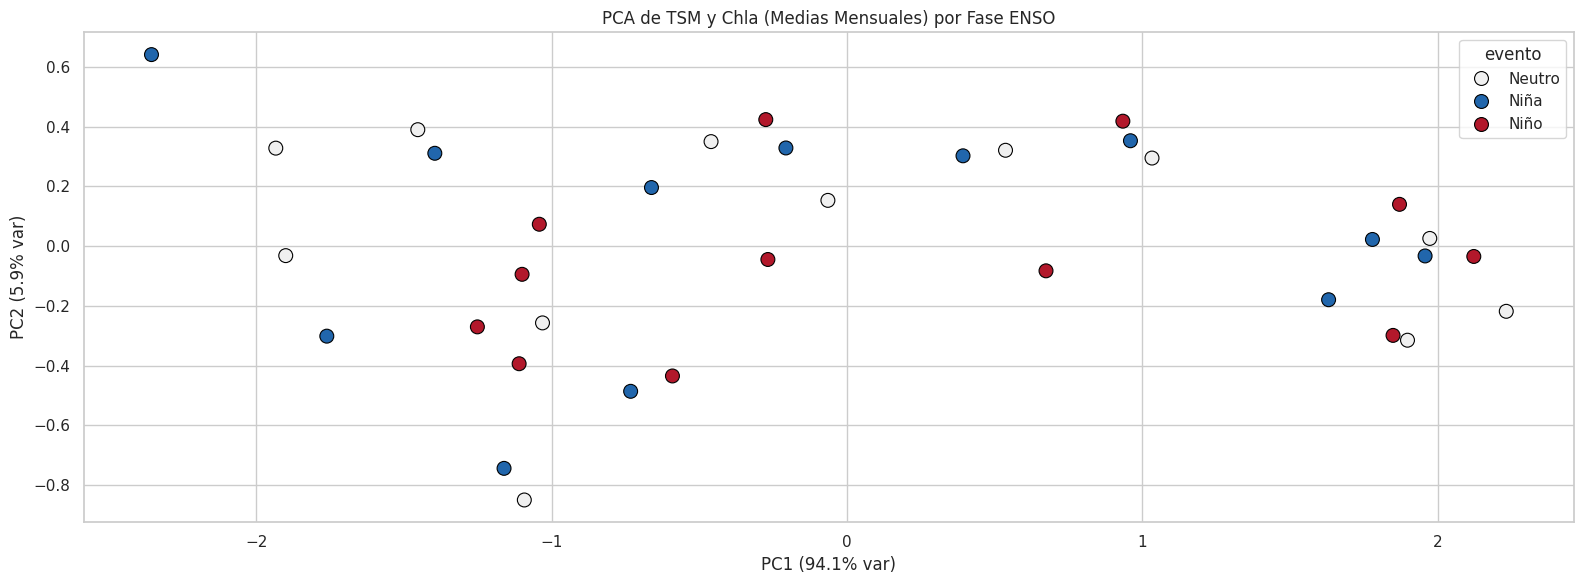


Contribución de cada variable a los componentes principales (PCA mensual):
        PC1    PC2
tsm   0.707  0.707
chla -0.707  0.707


In [200]:
df['fecha'] = pd.to_datetime(df['fecha'])
df['month'] = df['fecha'].dt.month
df['evento'] = df['evento'].astype('category')

tsm_month_mean = df.groupby('month')['tsm'].mean()
chla_month_mean = df.groupby('month')['chla'].mean()

tsm_month_var = df.groupby('month')['tsm'].var()
chla_month_var = df.groupby('month')['chla'].var()

# Calculo de Desviacion de la Media y de Desviacion de la Media de la Varianza (Total por Mes)
tsm_mean_dev = tsm_month_mean - tsm_month_mean.mean()
chla_mean_dev = chla_month_mean - chla_month_mean.mean()
tsm_var_dev = tsm_month_var - tsm_month_var.mean()
chla_var_dev = chla_month_var - chla_month_var.mean()

# Graficos de Desviacion de la Media y de Desviacion de la Media de la Varianza
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Desviacion de la Media
ax = axes[0]
for x, y in zip(tsm_mean_dev.index, tsm_mean_dev.values):
    color = 'green' if y >= 0 else 'red'
    ax.vlines(x, 0, y, color=color, linewidth=2)
    ax.plot(x, y, 'o', color=color)
for x, y in zip(chla_mean_dev.index, chla_mean_dev.values):
    color = 'green' if y >= 0 else 'red'
    ax.vlines(x, 0, y, color=color, linewidth=2, linestyle='dotted')
    ax.plot(x, y, 'x', color=color)
ax.axhline(0, color='black', linestyle='--')
ax.set_title("Desviación de la Media Mensual de TSM y Chla")
ax.set_ylabel("Desviación")
ax.set_xticks(range(1, 13))
ax.grid(True)

# Desviacion de la Varianza Media
ax = axes[1]
for x, y in zip(tsm_var_dev.index, tsm_var_dev.values):
    color = 'green' if y >= 0 else 'red'
    ax.vlines(x, 0, y, color=color, linewidth=2)
    ax.plot(x, y, 'o', color=color)
for x, y in zip(chla_var_dev.index, chla_var_dev.values):
    color = 'green' if y >= 0 else 'red'
    ax.vlines(x, 0, y, color=color, linewidth=2, linestyle='dotted')
    ax.plot(x, y, 'x', color=color)
ax.axhline(0, color='black', linestyle='--')
ax.set_title("Desviación de la Varianza Mensual de TSM y Chla")
ax.set_ylabel("Desviación")
ax.set_xlabel("Mes")
ax.set_xticks(range(1, 13))
ax.grid(True)

plt.tight_layout()
plt.show()

# Boxplots por mes y ENSO
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
sns.boxplot(data=df, x='month', y='tsm', hue='evento', palette=enso_colors, ax=axes[0])
axes[0].set_title("TSM por Mes y Fase ENSO")
sns.boxplot(data=df, x='month', y='chla', hue='evento', palette=enso_colors, ax=axes[1])
axes[1].set_title("Chla por Mes y Fase ENSO")
for ax in axes:
    ax.tick_params(axis='x', rotation=0)
    for m in range(1, 13):
        ax.axvline(x=m - 0.5, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Kruskal-Wallis & ANOVA por fase ENSO (media por mes)
monthly_means = df.groupby(['month', 'evento'], observed=False)[['tsm', 'chla']].mean().reset_index()
tsm_groups = [g['tsm'].dropna().values for _, g in monthly_means.groupby('evento', observed=False) if len(g) >= 2]
chla_groups = [g['chla'].dropna().values for _, g in monthly_means.groupby('evento', observed=False) if len(g) >= 2]
tsm_h, tsm_p_kruskal = kruskal(*tsm_groups)
tsm_f, tsm_p_anova = f_oneway(*tsm_groups)
chla_h, chla_p_kruskal = kruskal(*chla_groups)
chla_f, chla_p_anova = f_oneway(*chla_groups)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(data=monthly_means, x='evento', hue='evento', y='tsm', palette=enso_colors, ax=axes[0])
axes[0].set_title(f"TSM por ENSO (Mensual)\nKruskal p = {tsm_p_kruskal:.4f} | ANOVA p = {tsm_p_anova:.4f}")
sns.boxplot(data=monthly_means, x='evento', hue='evento', y='chla', palette=enso_colors, ax=axes[1])
axes[1].set_title(f"Chla por ENSO (Mensual)\nKruskal p = {chla_p_kruskal:.4f} | ANOVA p = {chla_p_anova:.4f}")
plt.tight_layout()
plt.show()

# PCA
monthly_means_clean = monthly_means.dropna(subset=['tsm', 'chla'])
X = monthly_means_clean[['tsm', 'chla']].values
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['evento'] = monthly_means_clean['evento'].values
pca_df['month'] = monthly_means_clean['month'].values

plt.figure(figsize=(16, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='evento', palette=enso_colors, s=100, edgecolor='black')
plt.title("PCA de TSM y Chla (Medias Mensuales) por Fase ENSO")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.grid(True)
plt.tight_layout()
plt.show()

loadings = pd.DataFrame(pca.components_.T, index=['tsm', 'chla'], columns=[f"PC{i+1}" for i in range(pca.n_components_)])
print("\nContribución de cada variable a los componentes principales (PCA mensual):")
print(loadings.round(3))

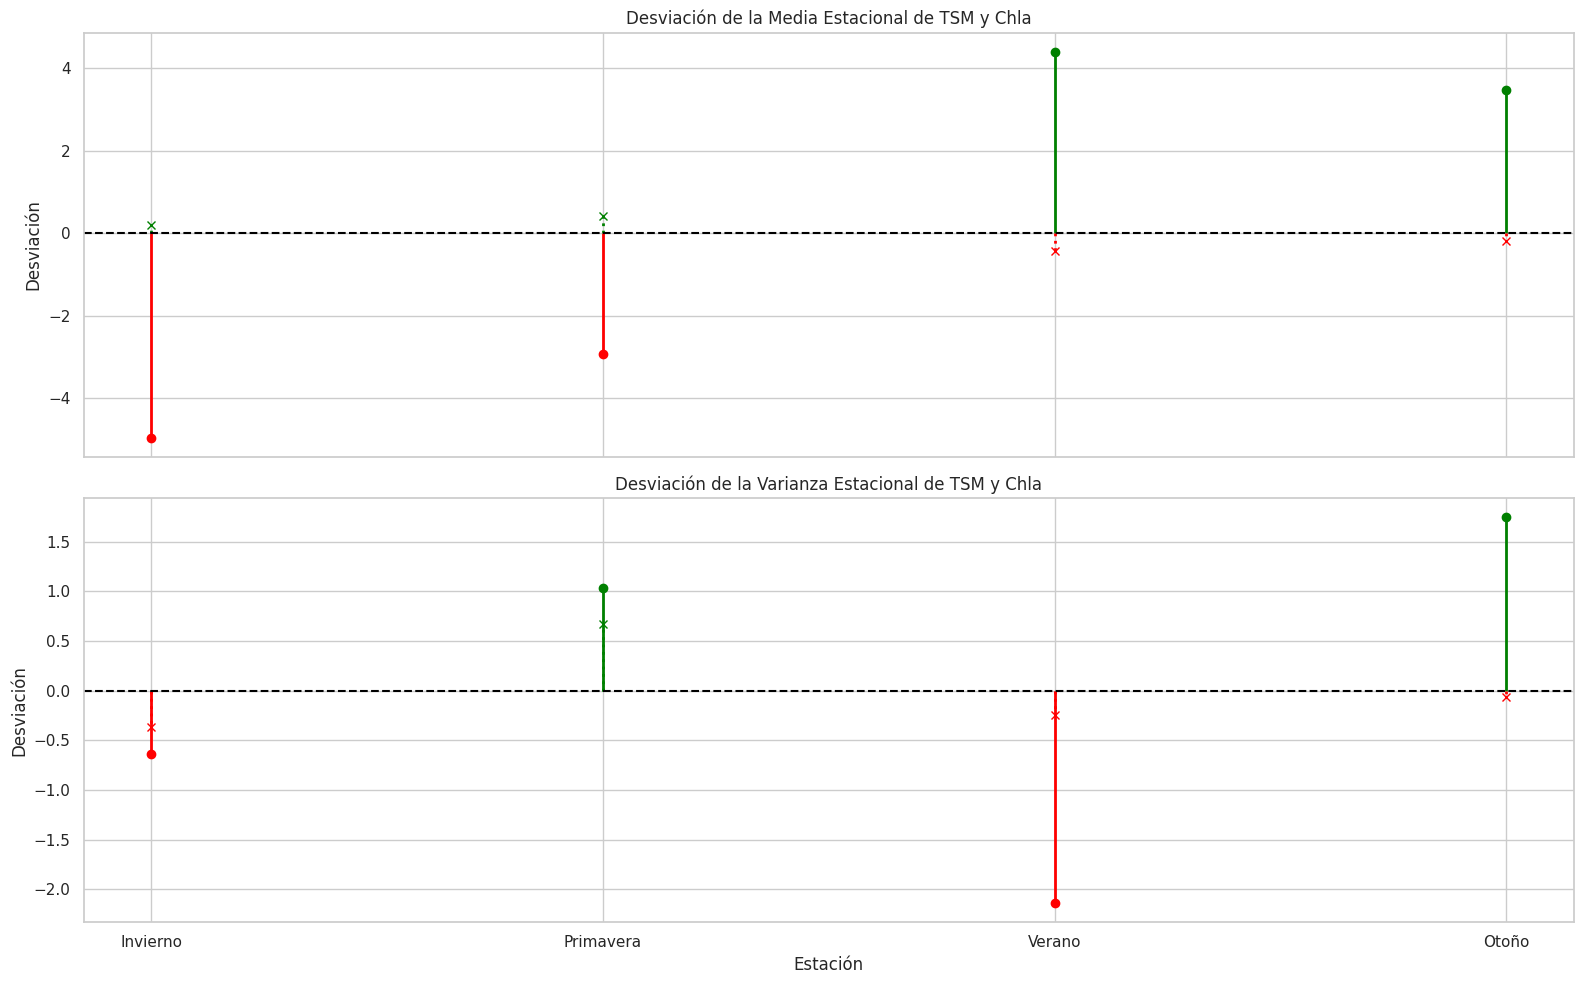

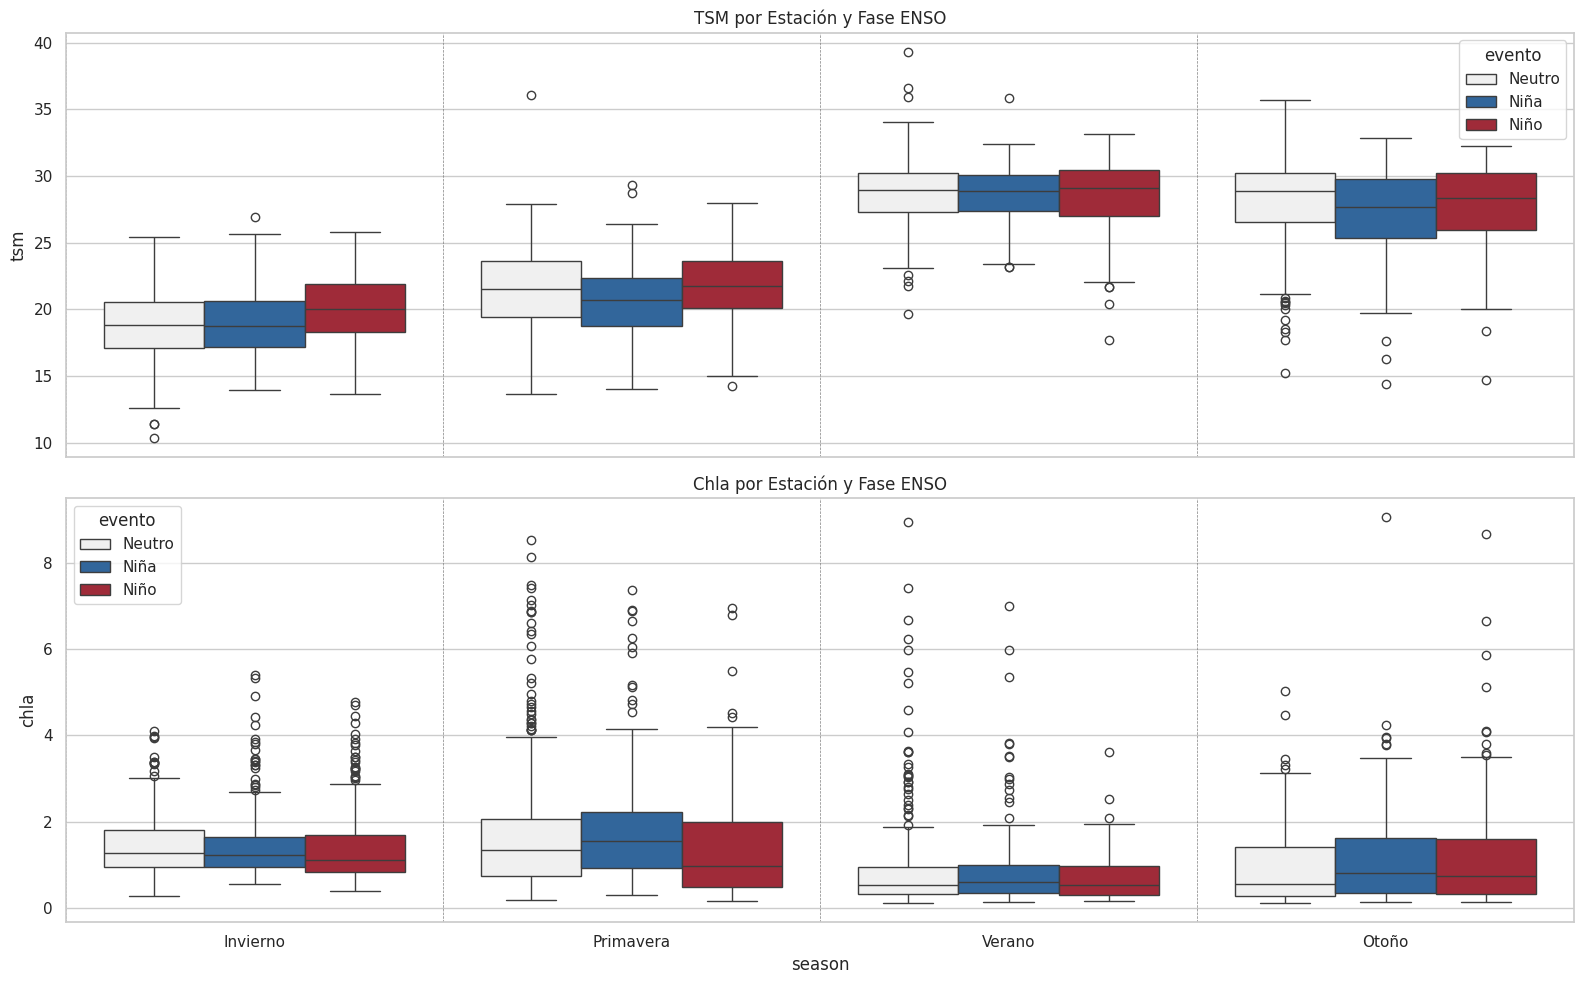

<ipython-input-201-2db7e573c070>:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tsm_groups = [g['tsm'].dropna().values for _, g in seasonal_means.groupby('evento') if len(g) >= 2]
<ipython-input-201-2db7e573c070>:91: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chla_groups = [g['chla'].dropna().values for _, g in seasonal_means.groupby('evento') if len(g) >= 2]


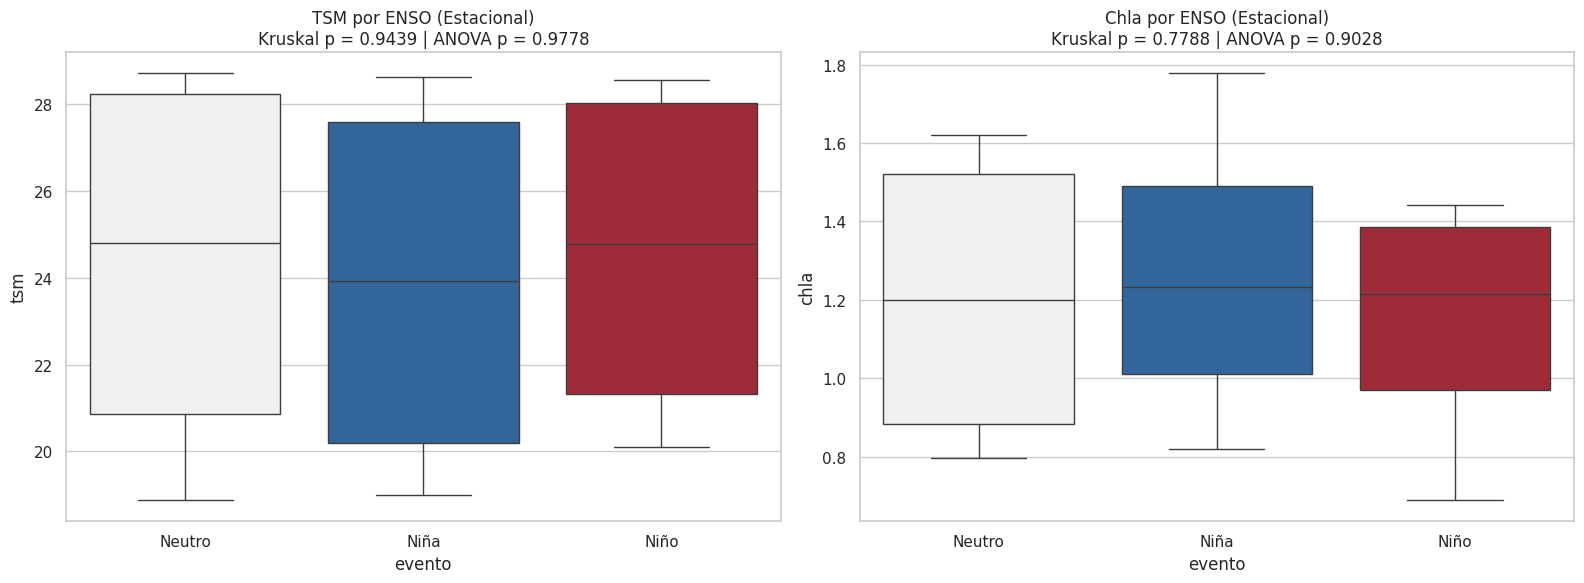

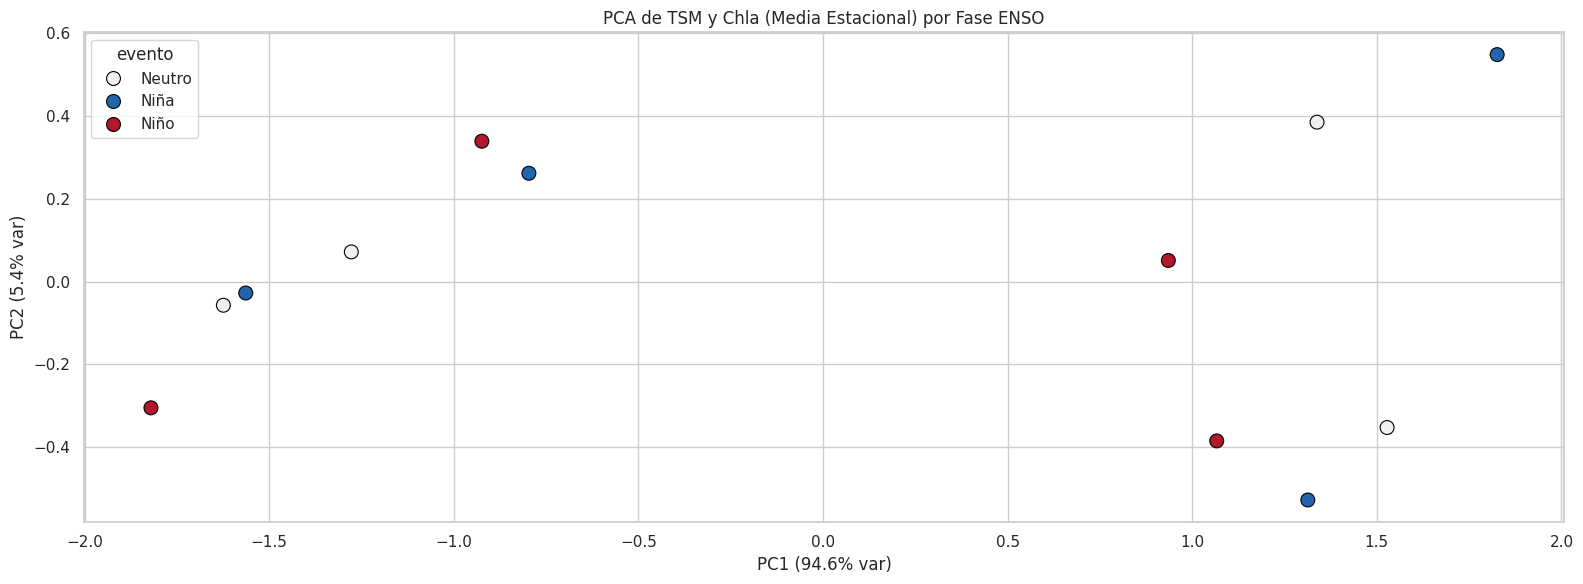


Contribución de cada variable a los componentes principales (PCA estacional):
        PC1    PC2
tsm  -0.707  0.707
chla  0.707  0.707


In [201]:
df['fecha'] = pd.to_datetime(df['fecha'])
df['month'] = df['fecha'].dt.month
df['evento'] = df['evento'].astype('category')

# Se categoriza por estacion climatologica
def get_season(month):
    if month in [12, 1, 2]:
        return 'Invierno'
    elif month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Verano'
    else:
        return 'Otoño'

df['season'] = df['month'].apply(get_season)
season_order = ['Invierno', 'Primavera', 'Verano', 'Otoño']

# Calculo de Media y de Varianza por estacion climatologica
tsm_season_mean = df.groupby('season')['tsm'].mean().reindex(season_order)
chla_season_mean = df.groupby('season')['chla'].mean().reindex(season_order)

tsm_season_var = df.groupby('season')['tsm'].var().reindex(season_order)
chla_season_var = df.groupby('season')['chla'].var().reindex(season_order)

# Calculo de desviacion de Media y de Varianza Media por estacion climatologica en todos los anios
tsm_mean_dev = tsm_season_mean - tsm_season_mean.mean()
chla_mean_dev = chla_season_mean - chla_season_mean.mean()
tsm_var_dev = tsm_season_var - tsm_season_var.mean()
chla_var_dev = chla_season_var - chla_season_var.mean()

# Graficos de Desviacion de la Media y de Desviacion de la Media de la Varianza
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Desviacion de la Media
ax = axes[0]
for x, y in enumerate(tsm_mean_dev):
    color = 'green' if y >= 0 else 'red'
    ax.vlines(x, 0, y, color=color, linewidth=2)
    ax.plot(x, y, 'o', color=color)
for x, y in enumerate(chla_mean_dev):
    color = 'green' if y >= 0 else 'red'
    ax.vlines(x, 0, y, color=color, linewidth=2, linestyle='dotted')
    ax.plot(x, y, 'x', color=color)
ax.axhline(0, color='black', linestyle='--')
ax.set_title("Desviación de la Media Estacional de TSM y Chla")
ax.set_ylabel("Desviación")
ax.set_xticks(range(4))
ax.set_xticklabels(season_order)
ax.grid(True)

# Desviacion de la Varianza Media
ax = axes[1]
for x, y in enumerate(tsm_var_dev):
    color = 'green' if y >= 0 else 'red'
    ax.vlines(x, 0, y, color=color, linewidth=2)
    ax.plot(x, y, 'o', color=color)
for x, y in enumerate(chla_var_dev):
    color = 'green' if y >= 0 else 'red'
    ax.vlines(x, 0, y, color=color, linewidth=2, linestyle='dotted')
    ax.plot(x, y, 'x', color=color)
ax.axhline(0, color='black', linestyle='--')
ax.set_title("Desviación de la Varianza Estacional de TSM y Chla")
ax.set_ylabel("Desviación")
ax.set_xlabel("Estación")
ax.set_xticks(range(4))
ax.set_xticklabels(season_order)
ax.grid(True)

plt.tight_layout()
plt.show()

# Boxplots por estacion y ENSO
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
sns.boxplot(data=df, x='season', y='tsm', hue='evento', palette=enso_colors, ax=axes[0], order=season_order)
axes[0].set_title("TSM por Estación y Fase ENSO")
sns.boxplot(data=df, x='season', y='chla', hue='evento', palette=enso_colors, ax=axes[1], order=season_order)
axes[1].set_title("Chla por Estación y Fase ENSO")
for ax in axes:
    ax.tick_params(axis='x', rotation=0)
    for i in range(4):
        ax.axvline(x=i - 0.5, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Kruskal-Wallis & ANOVA por fase ENSO (medias por estacion climatologica)
seasonal_means = df.groupby(['season', 'evento'], observed=False)[['tsm', 'chla']].mean().reset_index()
seasonal_means['season'] = pd.Categorical(seasonal_means['season'], categories=season_order, ordered=True)

tsm_groups = [g['tsm'].dropna().values for _, g in seasonal_means.groupby('evento') if len(g) >= 2]
chla_groups = [g['chla'].dropna().values for _, g in seasonal_means.groupby('evento') if len(g) >= 2]
tsm_h, tsm_p_kruskal = kruskal(*tsm_groups)
tsm_f, tsm_p_anova = f_oneway(*tsm_groups)
chla_h, chla_p_kruskal = kruskal(*chla_groups)
chla_f, chla_p_anova = f_oneway(*chla_groups)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(data=seasonal_means, x='evento', y='tsm', hue='evento', palette=enso_colors, ax=axes[0])
axes[0].set_title(f"TSM por ENSO (Estacional)\nKruskal p = {tsm_p_kruskal:.4f} | ANOVA p = {tsm_p_anova:.4f}")
sns.boxplot(data=seasonal_means, x='evento', y='chla', hue='evento', palette=enso_colors, ax=axes[1])
axes[1].set_title(f"Chla por ENSO (Estacional)\nKruskal p = {chla_p_kruskal:.4f} | ANOVA p = {chla_p_anova:.4f}")
plt.tight_layout()
plt.show()

# PCA
seasonal_means_clean = seasonal_means.dropna(subset=['tsm', 'chla'])
X = seasonal_means_clean[['tsm', 'chla']].values
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['evento'] = seasonal_means_clean['evento'].values
pca_df['season'] = seasonal_means_clean['season'].values

plt.figure(figsize=(16, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='evento', palette=enso_colors, s=100, edgecolor='black')
plt.title("PCA de TSM y Chla (Media Estacional) por Fase ENSO")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.grid(True)
plt.tight_layout()
plt.show()

loadings = pd.DataFrame(pca.components_.T, index=['tsm', 'chla'], columns=[f"PC{i+1}" for i in range(pca.n_components_)])
print("\nContribución de cada variable a los componentes principales (PCA estacional):")
print(loadings.round(3))

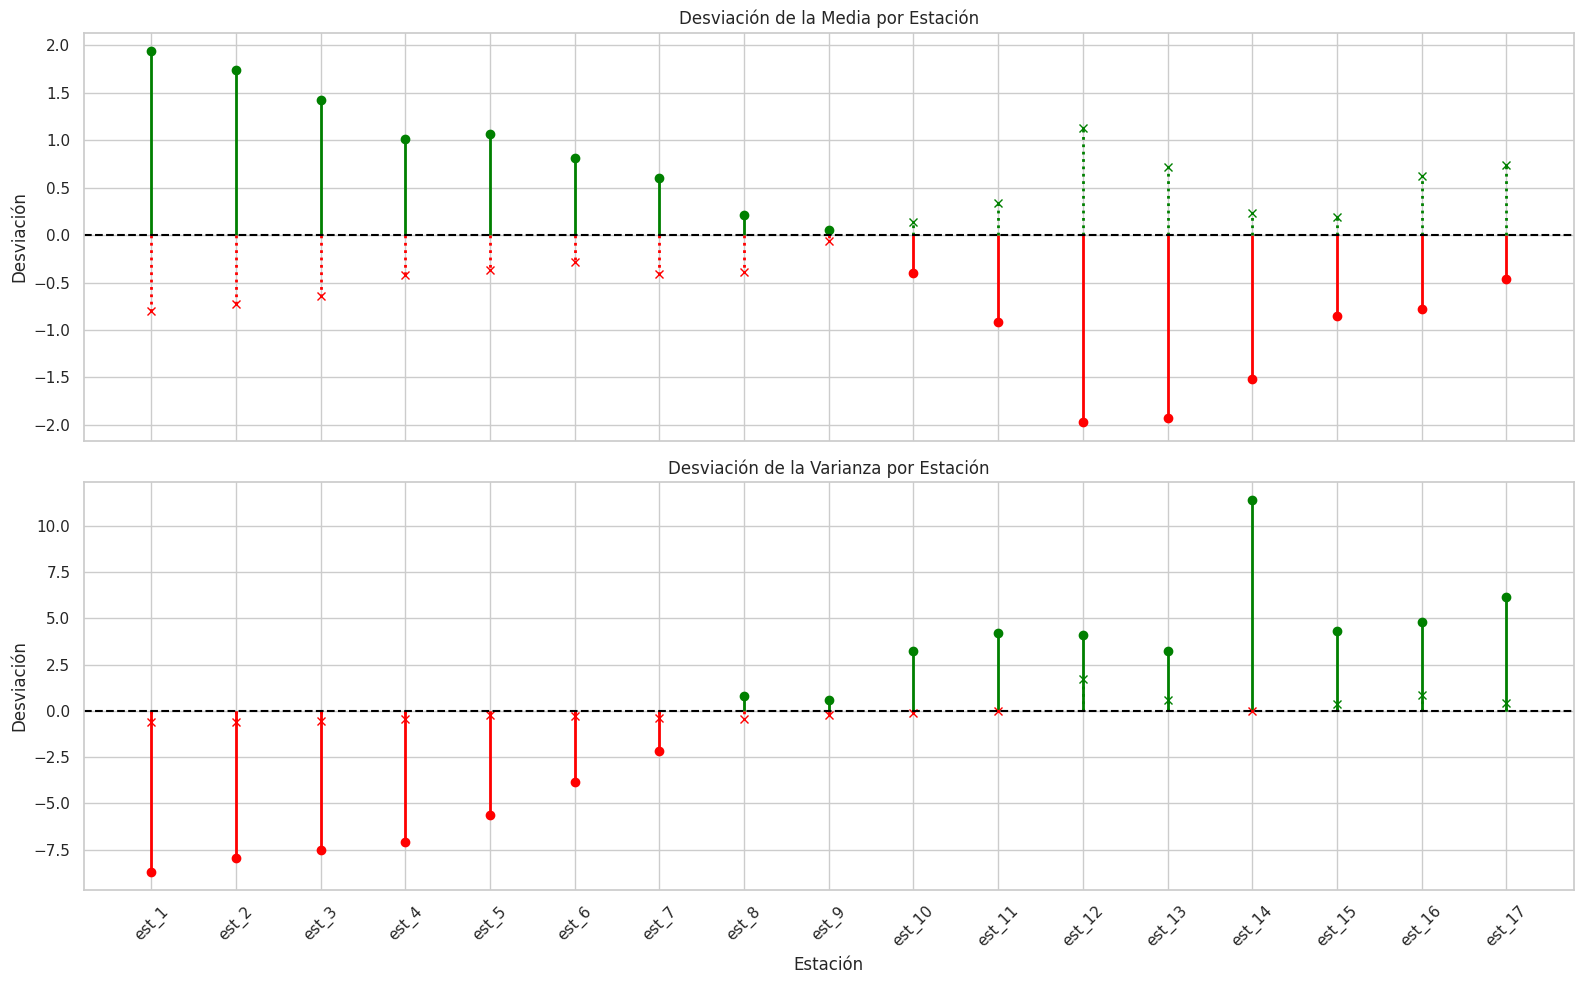

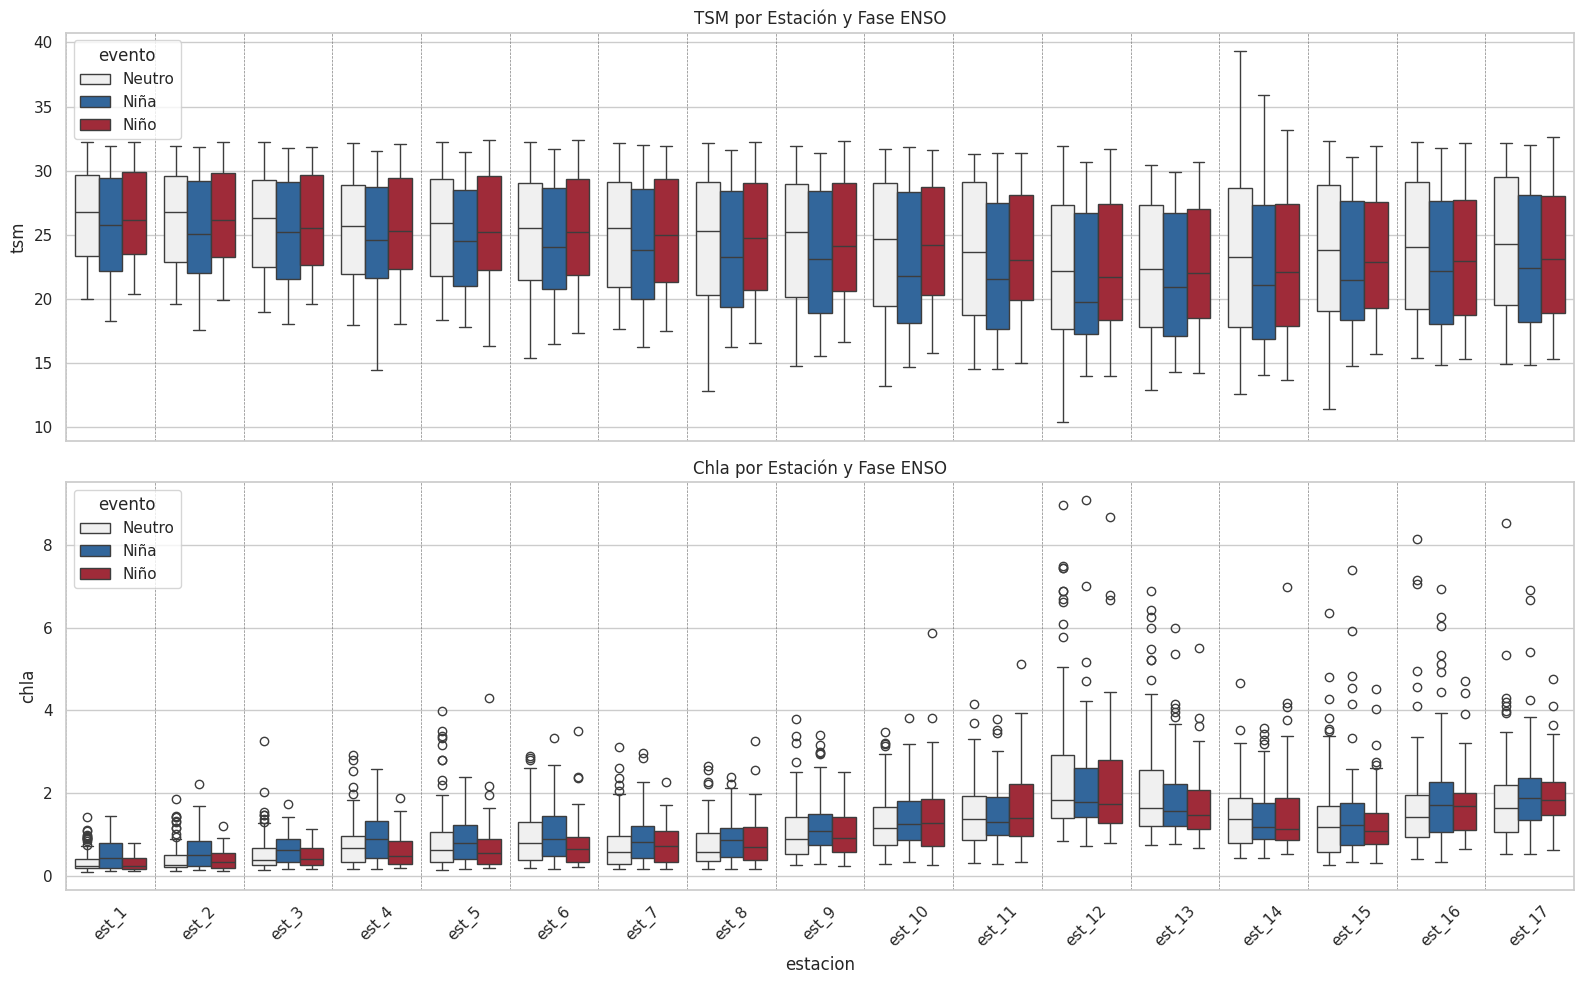

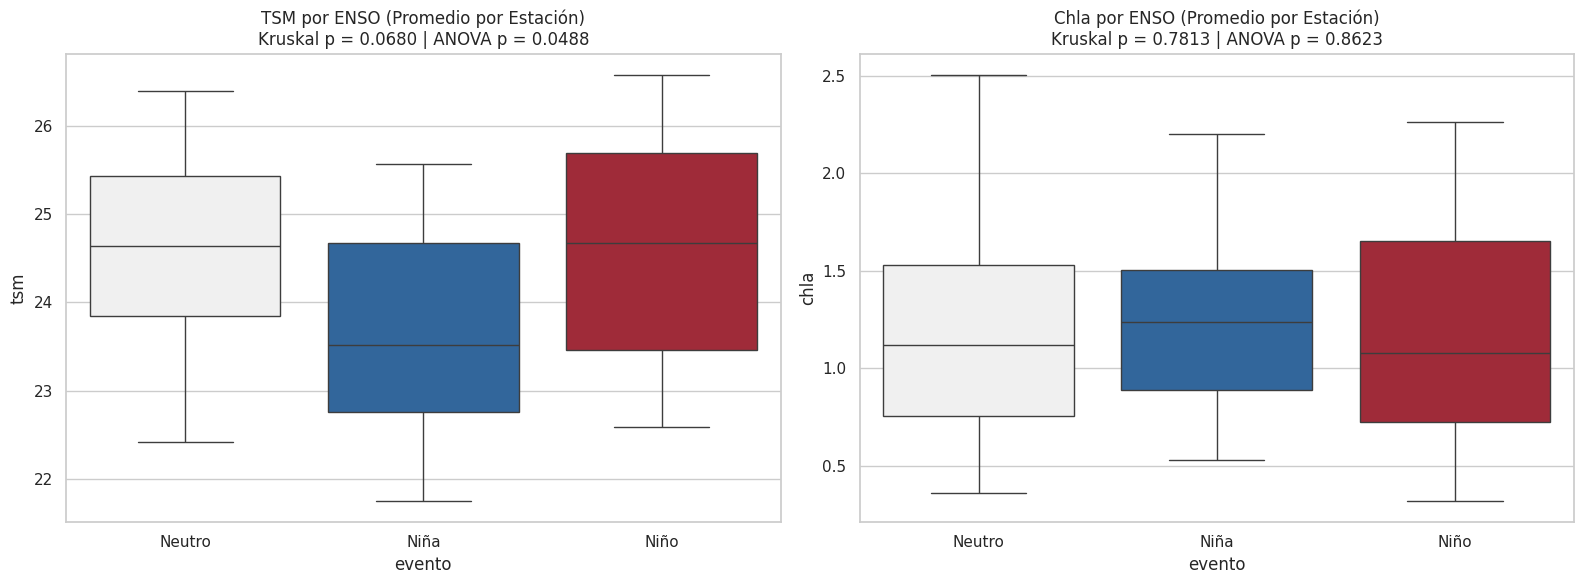

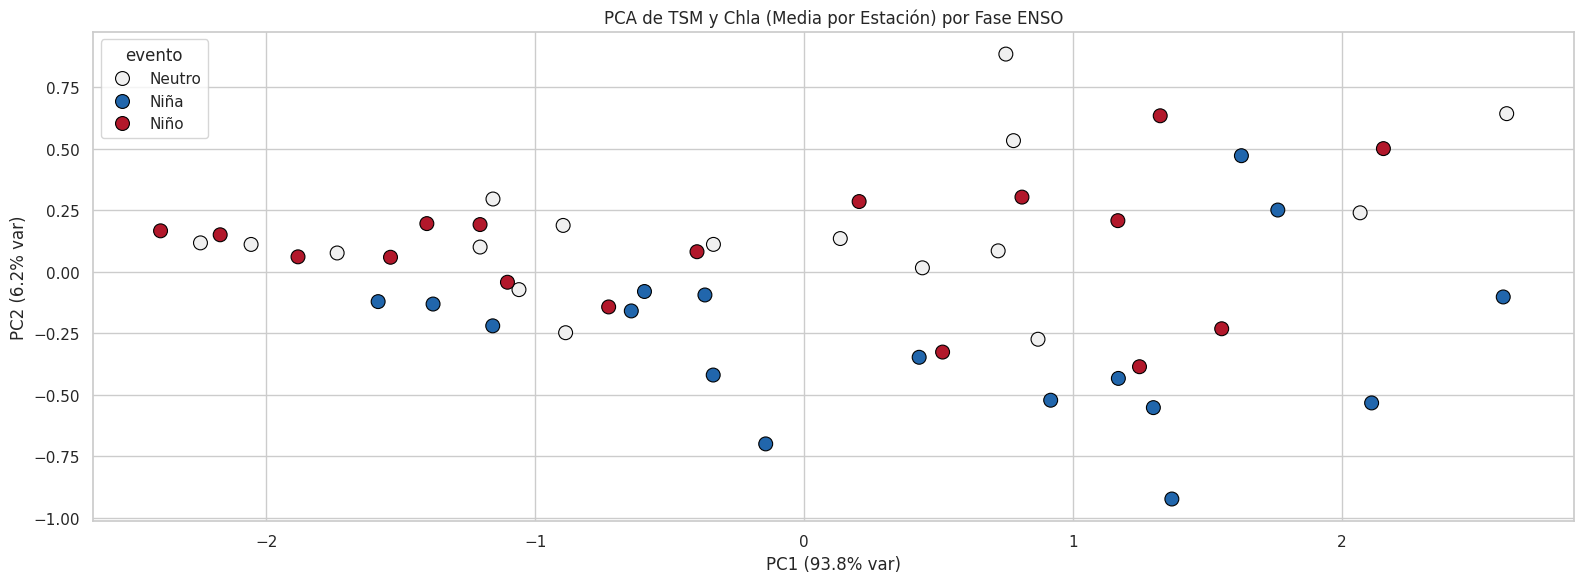


Contribución de cada variable a los componentes principales (PCA por estación):
        PC1    PC2
tsm  -0.707  0.707
chla  0.707  0.707


In [202]:


# --- Prepare groupings ---
df['fecha'] = pd.to_datetime(df['fecha'])
df['evento'] = df['evento'].astype('category')

# --- Get ordered list of estaciones (assume correct order exists) ---
estacion_order = sorted(df['estacion'].unique(), key=lambda x: int(x.split('_')[1]))

# --- ENSO color map ---
enso_colors = {"Niña": "#2166ac", "Neutro": "#f0f0f0", "Niño": "#b2182b"}

# --- Stational mean and variance ---
tsm_sta_mean = df.groupby('estacion')['tsm'].mean().reindex(estacion_order)
chla_sta_mean = df.groupby('estacion')['chla'].mean().reindex(estacion_order)

tsm_sta_var = df.groupby('estacion')['tsm'].var().reindex(estacion_order)
chla_sta_var = df.groupby('estacion')['chla'].var().reindex(estacion_order)

# Deviations
tsm_mean_dev = tsm_sta_mean - tsm_sta_mean.mean()
chla_mean_dev = chla_sta_mean - chla_sta_mean.mean()
tsm_var_dev = tsm_sta_var - tsm_sta_var.mean()
chla_var_dev = chla_sta_var - chla_sta_var.mean()

# Graficos de Desviacion de la Media y de Desviacion de la Media de la Varianza
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Desviacion de la Media
ax = axes[0]
for x, y in enumerate(tsm_mean_dev):
    color = 'green' if y >= 0 else 'red'
    ax.vlines(x, 0, y, color=color, linewidth=2)
    ax.plot(x, y, 'o', color=color)
for x, y in enumerate(chla_mean_dev):
    color = 'green' if y >= 0 else 'red'
    ax.vlines(x, 0, y, color=color, linewidth=2, linestyle='dotted')
    ax.plot(x, y, 'x', color=color)
ax.axhline(0, color='black', linestyle='--')
ax.set_title("Desviación de la Media por Estación")
ax.set_ylabel("Desviación")
ax.set_xticks(range(len(estacion_order)))
ax.set_xticklabels(estacion_order, rotation=45)
ax.grid(True)

# Desviacion de la Varianza Media
ax = axes[1]
for x, y in enumerate(tsm_var_dev):
    color = 'green' if y >= 0 else 'red'
    ax.vlines(x, 0, y, color=color, linewidth=2)
    ax.plot(x, y, 'o', color=color)
for x, y in enumerate(chla_var_dev):
    color = 'green' if y >= 0 else 'red'
    ax.vlines(x, 0, y, color=color, linewidth=2, linestyle='dotted')
    ax.plot(x, y, 'x', color=color)
ax.axhline(0, color='black', linestyle='--')
ax.set_title("Desviación de la Varianza por Estación")
ax.set_ylabel("Desviación")
ax.set_xlabel("Estación")
ax.set_xticks(range(len(estacion_order)))
ax.set_xticklabels(estacion_order, rotation=45)
ax.grid(True)

plt.tight_layout()
plt.show()

# Boxplots por estacion y ENSO
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
sns.boxplot(data=df, x='estacion', y='tsm', hue='evento', palette=enso_colors, ax=axes[0], order=estacion_order)
axes[0].set_title("TSM por Estación y Fase ENSO")
sns.boxplot(data=df, x='estacion', y='chla', hue='evento', palette=enso_colors, ax=axes[1], order=estacion_order)
axes[1].set_title("Chla por Estación y Fase ENSO")
for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    for i in range(len(estacion_order)):
        ax.axvline(x=i - 0.5, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Kruskal-Wallis & ANOVA por fase ENSO (medias por Estacion de Medicion)
stational_means = df.groupby(['estacion', 'evento'], observed=False)[['tsm', 'chla']].mean().reset_index()
stational_means['estacion'] = pd.Categorical(stational_means['estacion'], categories=estacion_order, ordered=True)

tsm_groups = [g['tsm'].dropna().values for _, g in stational_means.groupby('evento', observed=False) if len(g) >= 2]
chla_groups = [g['chla'].dropna().values for _, g in stational_means.groupby('evento', observed=False) if len(g) >= 2]
tsm_h, tsm_p_kruskal = kruskal(*tsm_groups)
tsm_f, tsm_p_anova = f_oneway(*tsm_groups)
chla_h, chla_p_kruskal = kruskal(*chla_groups)
chla_f, chla_p_anova = f_oneway(*chla_groups)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(data=stational_means, x='evento', hue='evento', y='tsm', palette=enso_colors, ax=axes[0])
axes[0].set_title(f"TSM por ENSO (Promedio por Estación)\nKruskal p = {tsm_p_kruskal:.4f} | ANOVA p = {tsm_p_anova:.4f}")
sns.boxplot(data=stational_means, x='evento', hue='evento', y='chla', palette=enso_colors, ax=axes[1])
axes[1].set_title(f"Chla por ENSO (Promedio por Estación)\nKruskal p = {chla_p_kruskal:.4f} | ANOVA p = {chla_p_anova:.4f}")
plt.tight_layout()
plt.show()

# PCA
stational_means_clean = stational_means.dropna(subset=['tsm', 'chla'])
X = stational_means_clean[['tsm', 'chla']].values
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['evento'] = stational_means_clean['evento'].values
pca_df['estacion'] = stational_means_clean['estacion'].values

plt.figure(figsize=(16, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='evento', palette=enso_colors, s=100, edgecolor='black')
plt.title("PCA de TSM y Chla (Media por Estación) por Fase ENSO")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.grid(True)
plt.tight_layout()
plt.show()

loadings = pd.DataFrame(pca.components_.T, index=['tsm', 'chla'], columns=[f"PC{i+1}" for i in range(pca.n_components_)])
print("\nContribución de cada variable a los componentes principales (PCA por estación):")
print(loadings.round(3))

Shapiro-Wilk: W = 0.955, p = 0.0512


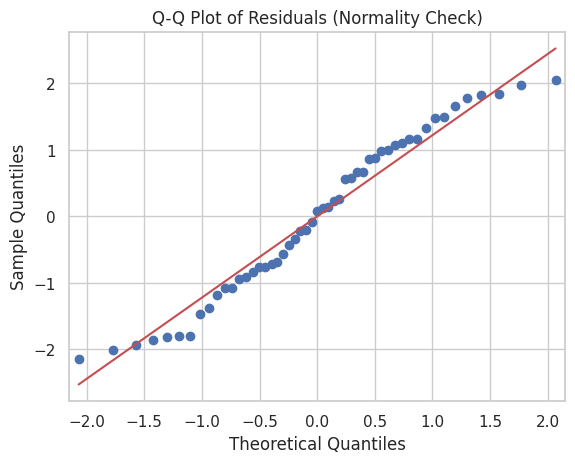

Levene: W = 0.295, p = 0.7460


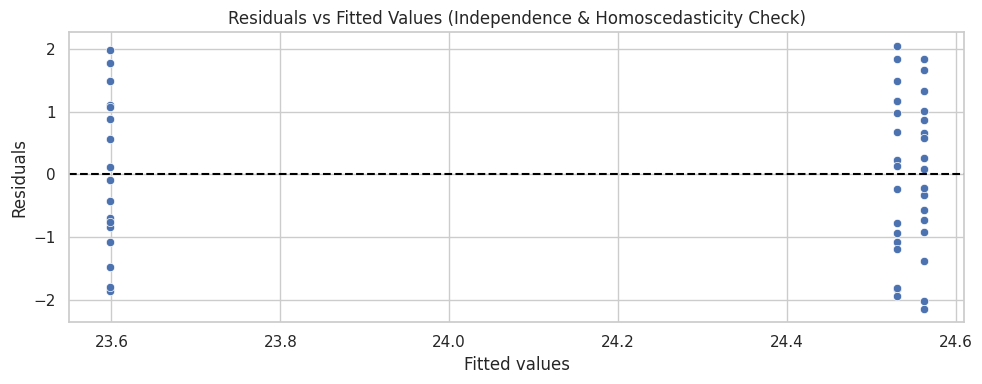

In [203]:
stational_means['evento'] = stational_means['evento'].astype('category')
stational_means['tsm'] = stational_means['tsm'].astype(float)

# Ajuste del ANOVA
model = smf.ols('tsm ~ C(evento)', data=stational_means).fit()

# Calculo residuales
residuals = model.resid

# Prueba de Normalidad (Shapiro-Wilk)
shapiro_stat, shapiro_p = shapiro(residuals)
print(f"Shapiro-Wilk: W = {shapiro_stat:.3f}, p = {shapiro_p:.4f}")

# Q-Q Plot
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals (Normality Check)")
plt.grid(True)
plt.show()

# Prueba de Homogeneidad de las Varianzas (Levene)
grouped = [group['tsm'].values for _, group in stational_means.groupby('evento', observed=False)]
levene_stat, levene_p = levene(*grouped)
print(f"Levene: W = {levene_stat:.3f}, p = {levene_p:.4f}")

# Residuales vs Ajustado
fitted_vals = model.fittedvalues
plt.figure(figsize=(10, 4))
sns.scatterplot(x=fitted_vals, y=residuals)
plt.axhline(0, linestyle='--', color='black')
plt.title("Residuals vs Fitted Values (Independence & Homoscedasticity Check)")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

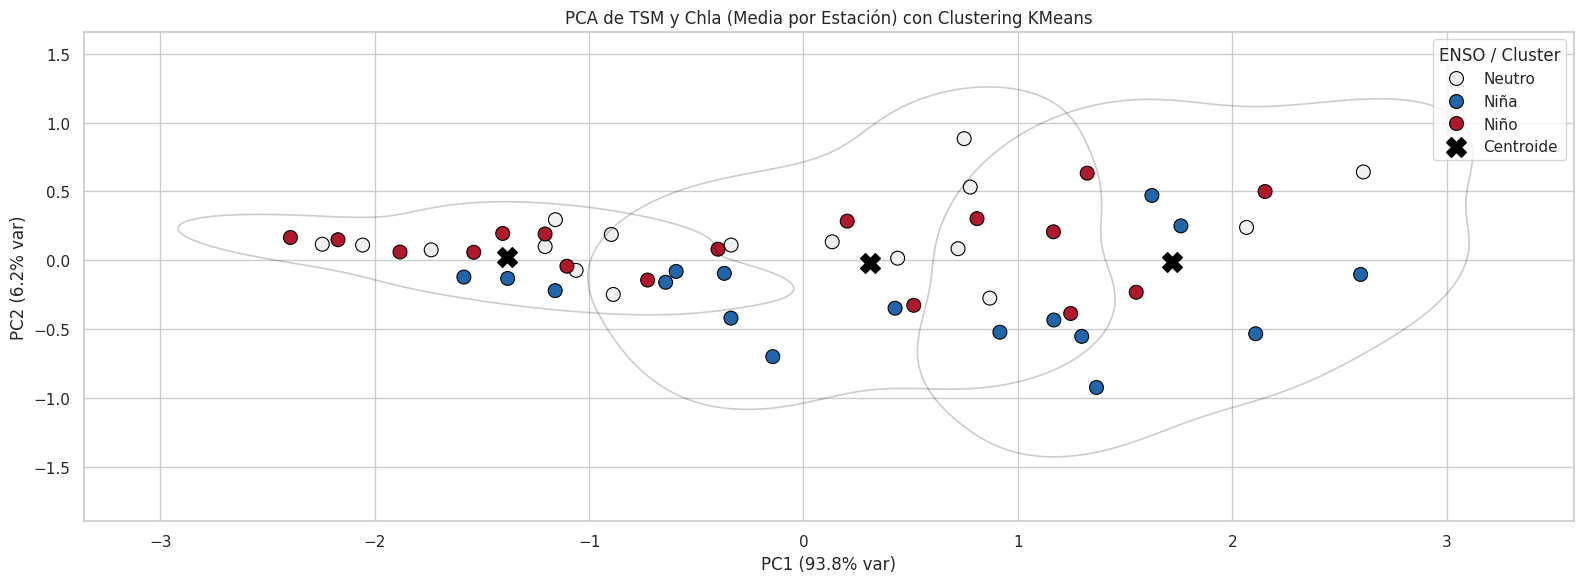

In [204]:
# PRUEBITAS, IGNOREN ESTO RAZA

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
pca_df['cluster'] = kmeans.fit_predict(pca_df[['PC1', 'PC2']])
centroids = kmeans.cluster_centers_

plt.figure(figsize=(16, 6))
scatter = sns.scatterplot(
    data=pca_df, x='PC1', y='PC2', hue='evento',
    palette=enso_colors, s=100, edgecolor='black'
)

plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, marker='X', label='Centroide')

for cluster_id in range(n_clusters):
    cluster_data = pca_df[pca_df['cluster'] == cluster_id]
    sns.kdeplot(
        x=cluster_data['PC1'], y=cluster_data['PC2'],
        levels=2, color='black', linewidths=1.2, alpha=0.2
    )

plt.title("PCA de TSM y Chla (Media por Estación) con Clustering KMeans")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.grid(True)
plt.legend(title='ENSO / Cluster')
plt.tight_layout()
plt.show()